# XGBoost timeseries price prediction

Here we use XGBoost to predict the future day. to do so we formulate the data relative to the current moment in time, the high, low and close of previous times. perhaps the last 30 days, or 7 or perhaps yesterday, and combining the last 7, and 30 and 90 into 4 datapoints of high, low, close each. or even combining days in a phi pattern: yesterday, the day before that, combining 2 days before that, 3 days before that, 5 days before that, 8 days before that, 13 days before that, 21 days before that, 34 days before that. doing so with phi would give us 88 days, nearly a quarter. or perhaps we make it simpler, and more typical to human time: the last 1 day, the last 7 days, the last 30 days, the last 90 days as 4 datapoints. Whatever gives us the best results. We then constantly look for better hyperparams locally. Lastly, we build 3 models one to predict close, one to predict high, and one to predict low.

So, here's the framework design:
```
main():
    Loop
        get data
        if new data detected
            incrementally add data to raw dataset
            remake model
            score model (take care not to overfit)
            make prediction
            display / make available the prediction as "stable"
        generate random seeds (to see how much we randomize a new model)
        produce new model inputs
        set new model hyper params
        make new model (take care not to overfit)
        score new model
        compare against original model
        if better
            (save model to version list)
            set default hyper params to new model params
            set inputs to new model inputs
            make prediction
            display / make available as "edge"
        
generate seeds():
    inputs seed = 0-do nothing-.35-drop one-.55-add one-.75-drop and add one-.95-randomize-1
    params seed = 0-do nothing-.10-incrementally randomize (within local limits)-.90-randomize (within global limits)-1
    randomize inputs(): 
        out of all possible inputs (catalogue of pipelines) choose 10-100 and compile into feature set
    drop one():
        take current feature set and drop one at random
    add one():
        out of all possible inputs (catalogue of pipelines) choose 1 and compile, append to feature set
    randomize params(): 
        for all params, choose a random value within the global limits
    incremental params():
        for each param, choose a random value within the local limits
``` 

In [21]:
import random
abcd = [1,2,3]
abcd.remove(random.choice(abcd))
abcd

[1, 2]

## imports

In [22]:
#!pip install --upgrade pip --user
#!pip install xgboost
#!pip install seaborn

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
big = {'figsize':(16,10)}
verbose = False

## dataset

,Date,High,Low,Close
0,2003-12-01,0.837240,0.830560,0.835770
1,2003-12-02,0.837100,0.825830,0.827200
2,2003-12-03,0.828020,0.824400,0.824880
3,2003-12-04,0.830290,0.823450,0.827750
4,2003-12-05,0.828780,0.820280,0.820550
...,...,...,...,...
4638,2021-09-09,0.847020,0.844500,0.846088
4639,2021-09-10,0.846070,0.843668,0.845600
4640,2021-09-13,0.849574,0.846200,0.846600
4641,2021-09-14,0.847314,0.844096,0.846600


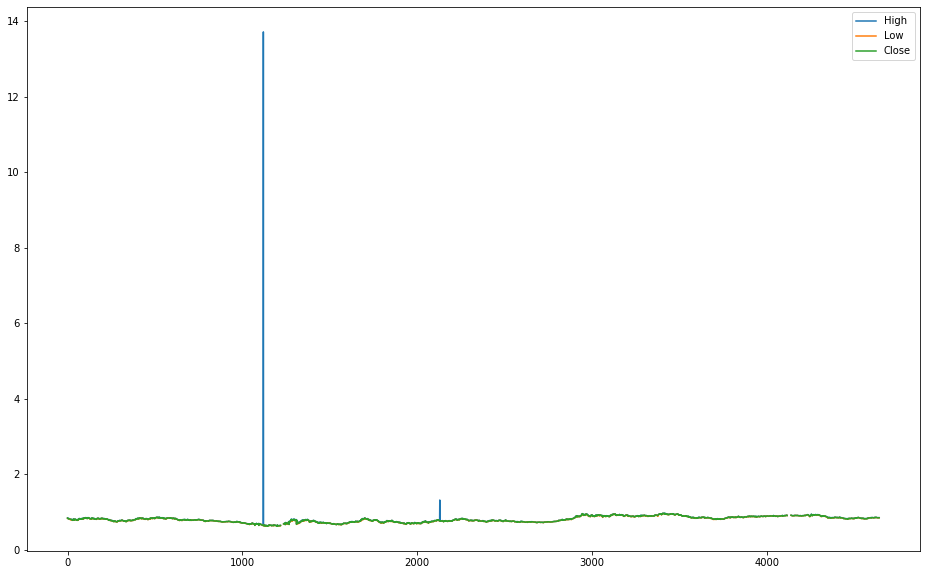

In [24]:
df = pd.read_csv("../../data/demo/EUR=X.csv", parse_dates=True)
df['Close'] = df['Adj Close']
df.drop(['Adj Close', 'Volume', 'Open'], axis=1, inplace=True)
df.plot(**big)
df

## cleanup

In [25]:
df['High'].max()

13.717

In [26]:
df['High'].idxmax()

1120

In [27]:
df.iloc[df['High'].idxmax()]

Date     2008-03-17
High         13.717
Low         0.62881
Close         0.635
Name: 1120, dtype: object

In [28]:
df.iloc[df['High'].idxmax()-1]

Date     2008-03-14
High        0.64354
Low         0.63767
Close       0.64029
Name: 1119, dtype: object

In [29]:
df.iloc[df['High'].idxmax()+1].High

0.64033

In [30]:
df.iloc[df['High'].idxmax()] = (df.iloc[df['High'].idxmax()-1].High + df.iloc[df['High'].idxmax()-1].High) / 2

In [31]:
df['High'].max()

1.3148

In [32]:
df['High'].idxmax()

2129

In [33]:
df.iloc[df['High'].idxmax()] = (df.iloc[df['High'].idxmax()-1].High + df.iloc[df['High'].idxmax()-1].High) / 2

<AxesSubplot:>

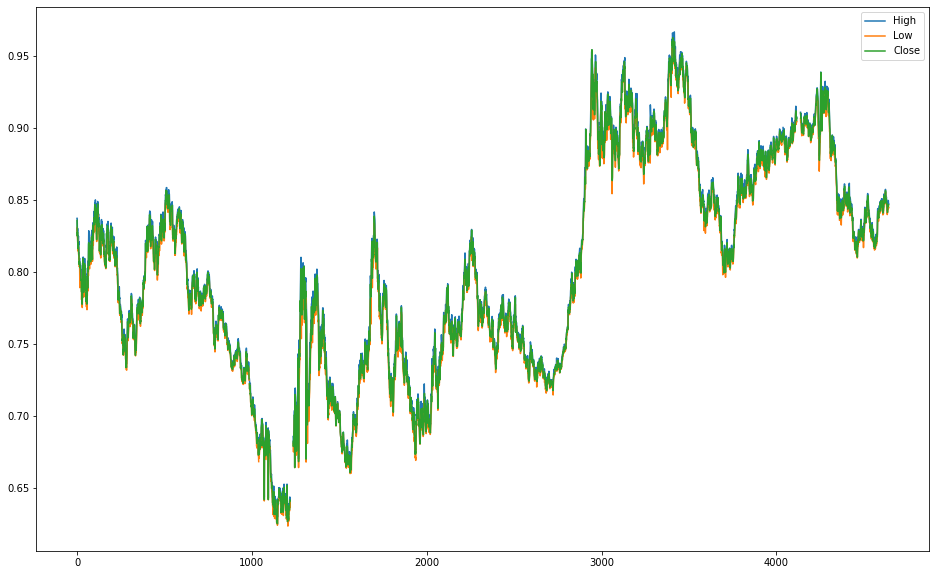

In [34]:
df.plot(**big)

<AxesSubplot:>

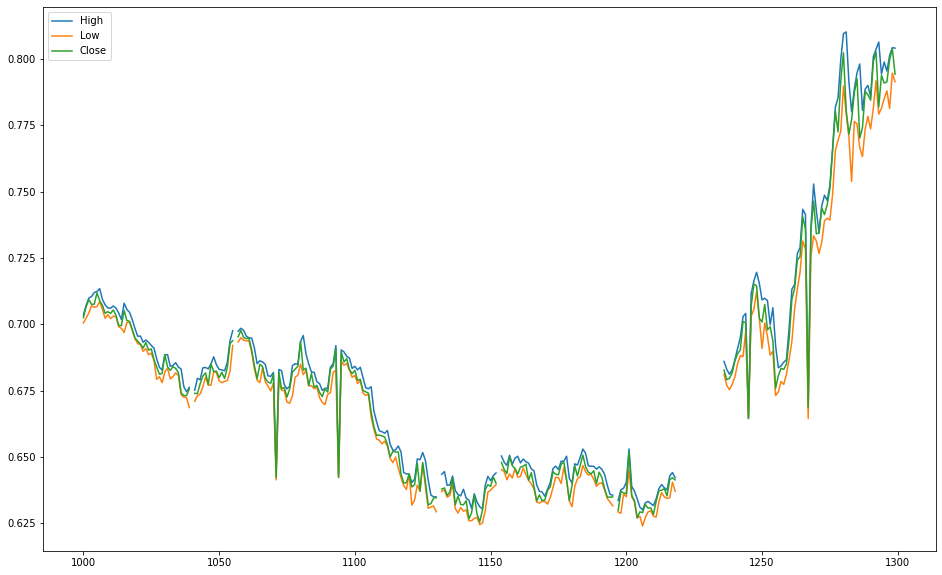

In [35]:
df.iloc[1000:1300].plot(**big)

<AxesSubplot:>

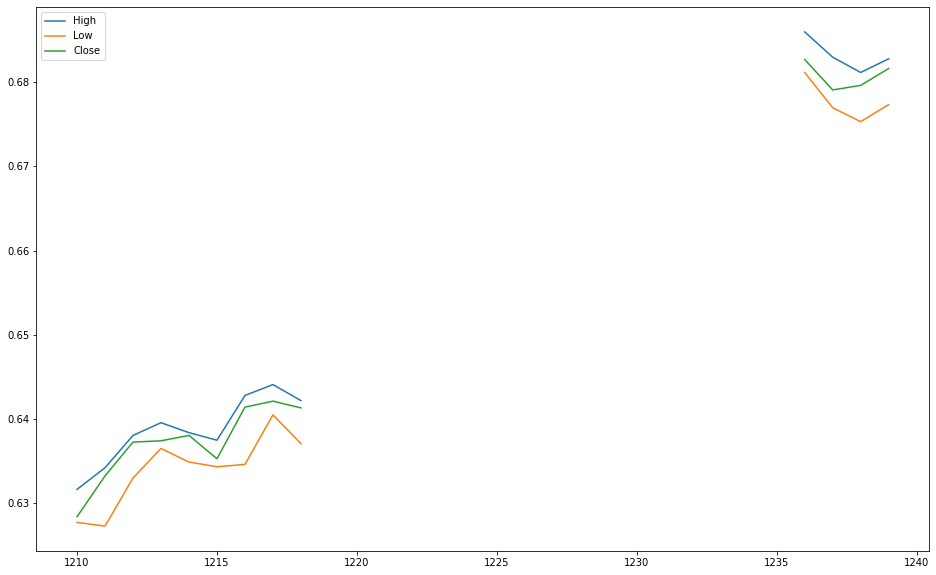

In [36]:
df.iloc[1210:1240].plot(**big)

In [37]:
df.iloc[1220]

Date     2008-08-04
High            NaN
Low             NaN
Close           NaN
Name: 1220, dtype: object

,High,Low,Close
0,0.837240,0.830560,0.835770
1,0.837100,0.825830,0.827200
2,0.828020,0.824400,0.824880
3,0.830290,0.823450,0.827750
4,0.828780,0.820280,0.820550
...,...,...,...
4589,0.847020,0.844500,0.846088
4590,0.846070,0.843668,0.845600
4591,0.849574,0.846200,0.846600
4592,0.847314,0.844096,0.846600


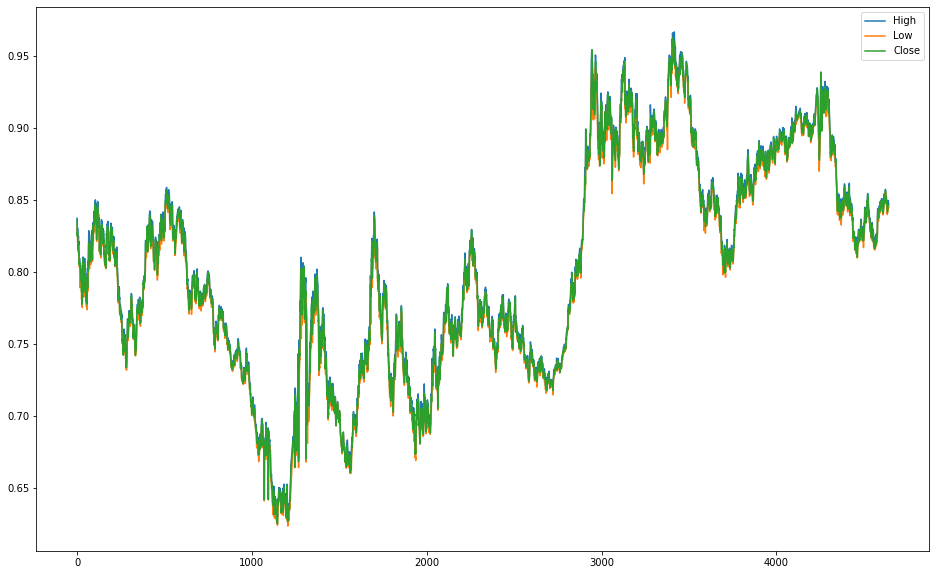

In [38]:
df.drop(['Date'], axis=1, inplace=True)
# perhaps we want to keep date. really we want to know the day of week, the day of month and month of year. that's it.
# but we'll handle that later.
df.dropna(inplace=True)
df.plot(**big)
df.reset_index(drop=True, inplace=True)
raw = df.copy()
original = df.copy()
df

In [39]:
#df.to_csv("../data/demo/EUR=X-simpleCleaned.csv", index=False)

## conforming the data to a relative format

In [40]:
# remember, the lastest time is at the bottom
df['High1'] = df['High'].shift(1)
df

,High,Low,Close,High1
0,0.837240,0.830560,0.835770,NaN
1,0.837100,0.825830,0.827200,0.837240
2,0.828020,0.824400,0.824880,0.837100
3,0.830290,0.823450,0.827750,0.828020
4,0.828780,0.820280,0.820550,0.830290
...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.847230
4590,0.846070,0.843668,0.845600,0.847020
4591,0.849574,0.846200,0.846600,0.846070
4592,0.847314,0.844096,0.846600,0.849574


In [41]:
df['High1'] =  df['High'] /df['High1'] 
df

,High,Low,Close,High1
0,0.837240,0.830560,0.835770,NaN
1,0.837100,0.825830,0.827200,0.999833
2,0.828020,0.824400,0.824880,0.989153
3,0.830290,0.823450,0.827750,1.002741
4,0.828780,0.820280,0.820550,0.998181
...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752
4590,0.846070,0.843668,0.845600,0.998878
4591,0.849574,0.846200,0.846600,1.004142
4592,0.847314,0.844096,0.846600,0.997340


In [42]:
#thats the same as percentage change
df['High'].pct_change()+1

0            NaN
1       0.999833
2       0.989153
3       1.002741
4       0.998181
          ...   
4589    0.999752
4590    0.998878
4591    1.004142
4592    0.997340
4593    0.999865
Name: High, Length: 4594, dtype: float64

In [43]:
df['High1'] = df['High'].pct_change()+1
df['Low1'] = df['Low'].pct_change()+1
df['Close1'] = df['Close'].pct_change()+1
df
# yesterday done

,High,Low,Close,High1,Low1,Close1
0,0.837240,0.830560,0.835770,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302
...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000


In [44]:
df['High2'] = df['High1'].shift(1)
df['Low2'] = df['Low1'].shift(1)
df['Close2'] = df['Close1'].shift(1)
df
# yesterday's yesterday

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2
0,0.837240,0.830560,0.835770,NaN,NaN,NaN,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746,NaN,NaN,NaN
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302,1.002741,0.998848,1.003479
...,...,...,...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183


In [45]:
# the way to calculate without relying on more recent days
df['High3'] = df['High'].shift(2) / df['High'].shift(3)
df['Low3'] = df['Low'].shift(2) / df['Low'].shift(3)
df['Close3'] = df['Close'].shift(2) / df['Close'].shift(3)
df
# yesterday's yesterday's yesterday

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2,High3,Low3,Close3
0,0.837240,0.830560,0.835770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195
...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,1.001584,0.999881,1.000915
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423


In [46]:
df['High7'] = df['High'].shift(1).rolling(window=7).max()
df['Low7'] = df['Low'].shift(1).rolling(window=7).min()
df['High7'] = df['High'].shift(1) / df['High7']
df['Low7'] = df['Low'].shift(1) / df['Low7']
df 
# past 7 days (one week)

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2,High3,Low3,Close3,High7,Low7
0,0.837240,0.830560,0.835770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,1.001584,0.999881,1.000915,0.999316,1.004521
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,0.999068,1.005597
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,0.998631,1.004606
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,1.000000,1.007621


In [47]:
df['High30'] = df['High'].shift(1).rolling(window=30).max()
df['Low30'] = df['Low'].shift(1).rolling(window=30).min()
df['High30'] = df['High'].shift(1) / df['High30']
df['Low30'] = df['Low'].shift(1) / df['Low30']
df 
# past 30 days (one month)

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2,High3,Low3,Close3,High7,Low7,High30,Low30
0,0.837240,0.830560,0.835770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,1.001584,0.999881,1.000915,0.999316,1.004521,0.988288,1.004808
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,0.999068,1.005597,0.988043,1.005884
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,0.998631,1.004606,0.986935,1.004606
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,1.000000,1.007621,0.991023,1.007621


In [48]:
df['High90'] = df['High'].shift(1).rolling(window=90).max()
df['Low90'] = df['Low'].shift(1).rolling(window=90).min()
df['High90'] = df['High'].shift(1) / df['High90']
df['Low90'] = df['Low'].shift(1) / df['Low90']
df 
# past 90 days (one quarter)

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2,High3,Low3,Close3,High7,Low7,High30,Low30,High90,Low90
0,0.837240,0.830560,0.835770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.837100,0.825830,0.827200,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.828020,0.824400,0.824880,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.830290,0.823450,0.827750,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,0.999833,0.994305,0.989746,NaN,NaN,NaN,NaN,NaN,NaN
4,0.828780,0.820280,0.820550,0.998181,0.996150,0.991302,1.002741,0.998848,1.003479,0.989153,0.998268,0.997195,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,1.001584,0.999881,1.000915,0.999316,1.004521,0.988288,1.004808,0.988288,1.034841
4590,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,0.999068,1.005597,0.988043,1.005884,0.988043,1.035948
4591,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,0.998631,1.004606,0.986935,1.004606,0.986935,1.034928
4592,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,1.000000,1.007621,0.991023,1.007621,0.991023,1.038034


In [49]:
df = df.dropna(axis=0)
df.reset_index(drop=True, inplace=True)
df

,High,Low,Close,High1,Low1,Close1,High2,Low2,Close2,High3,Low3,Close3,High7,Low7,High30,Low30,High90,Low90
0,0.834030,0.824670,0.832430,1.009844,1.020278,1.009655,1.012467,1.001053,1.019463,0.993230,0.994911,0.995789,0.996453,1.001053,0.996453,1.027405,0.986455,1.044465
1,0.834100,0.823320,0.824330,1.000084,0.998363,0.990269,1.009844,1.020278,1.009655,1.012467,1.001053,1.019463,1.000000,1.021352,1.000000,1.048238,0.996333,1.065644
2,0.829260,0.819810,0.821960,0.994197,0.995737,0.997125,1.000084,0.998363,0.990269,1.009844,1.020278,1.009655,1.000000,1.019680,1.000000,1.045951,1.000000,1.063900
3,0.828710,0.818530,0.828020,0.999337,0.998439,1.007373,0.994197,0.995737,0.997125,1.000084,0.998363,0.990269,0.994197,1.015333,0.994197,1.028130,0.994197,1.059364
4,0.828710,0.825560,0.827400,1.000000,1.008589,0.999251,0.999337,0.998439,1.007373,0.994197,0.995737,0.997125,0.993538,1.013747,0.993538,1.026524,0.993538,1.057710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4499,0.847020,0.844500,0.846088,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,1.001584,0.999881,1.000915,0.999316,1.004521,0.988288,1.004808,0.988288,1.034841
4500,0.846070,0.843668,0.845600,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,1.002976,1.002850,1.002660,0.999068,1.005597,0.988043,1.005884,0.988043,1.035948
4501,0.849574,0.846200,0.846600,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,0.999752,1.001070,1.002070,0.998631,1.004606,0.986935,1.004606,0.986935,1.034928
4502,0.847314,0.844096,0.846600,0.997340,0.997514,1.000000,1.004142,1.003001,1.001183,0.998878,0.999015,0.999423,1.000000,1.007621,0.991023,1.007621,0.991023,1.038034


## train test split

In [50]:
features = [
    #'Close1','High1','Low1',
    'Close2','High2','Low2','High7','Low7','High30','Low30','High90','Low90']
labels = ['High1', 'Low1', 'Close1']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[labels[0]], test_size=0.20, shuffle=False)
X_train

,Close2,High2,Low2,High7,Low7,High30,Low30,High90,Low90
0,1.019463,1.012467,1.001053,0.996453,1.001053,0.996453,1.027405,0.986455,1.044465
1,1.009655,1.009844,1.020278,1.000000,1.021352,1.000000,1.048238,0.996333,1.065644
2,0.990269,1.000084,0.998363,1.000000,1.019680,1.000000,1.045951,1.000000,1.063900
3,0.997125,0.994197,0.995737,0.994197,1.015333,0.994197,1.028130,0.994197,1.059364
4,1.007373,0.999337,0.998439,0.993538,1.013747,0.993538,1.026524,0.993538,1.057710
...,...,...,...,...,...,...,...,...,...
3598,1.003217,0.999840,0.998395,0.998308,1.016451,0.991258,1.016451,0.940845,1.016451
3599,0.997690,1.004852,1.000741,1.000000,1.007478,0.996067,1.017205,0.945410,1.017205
3600,1.006971,1.002787,1.008395,1.000000,1.013576,0.998843,1.025744,0.948045,1.025744
3601,1.003204,1.002565,1.001726,1.000000,1.010885,1.000000,1.027515,0.950476,1.027515


In [51]:
X_test

,Close2,High2,Low2,High7,Low7,High30,Low30,High90,Low90
3603,0.996380,0.998150,0.998557,0.990427,1.000531,0.990427,1.016991,0.941377,1.016991
3604,0.998288,0.995483,0.994233,0.985953,1.000000,0.985953,1.011126,0.937124,1.011126
3605,0.993548,0.995573,0.998336,0.981588,1.000000,0.981588,1.009444,0.932976,1.009444
3606,1.000161,1.006478,0.999664,0.987947,1.000000,0.987947,1.009105,0.939020,1.009105
3607,1.008777,1.002510,1.008998,0.990427,1.008998,0.990427,1.018184,0.941377,1.018184
...,...,...,...,...,...,...,...,...,...
4499,1.002660,1.002976,1.002850,0.999316,1.004521,0.988288,1.004808,0.988288,1.034841
4500,1.002070,0.999752,1.001070,0.999068,1.005597,0.988043,1.005884,0.988043,1.035948
4501,0.999423,0.998878,0.999015,0.998631,1.004606,0.986935,1.004606,0.986935,1.034928
4502,1.001183,1.004142,1.003001,1.000000,1.007621,0.991023,1.007621,0.991023,1.038034


In [52]:
y_train

0       1.009844
1       1.000084
2       0.994197
3       0.999337
4       1.000000
          ...   
3598    1.004852
3599    1.002787
3600    1.002565
3601    0.992263
3602    0.998150
Name: High1, Length: 3603, dtype: float64

In [53]:
y_test

3603    0.995483
3604    0.995573
3605    1.006478
3606    1.002510
3607    0.998711
          ...   
4499    0.999752
4500    0.998878
4501    1.004142
4502    0.997340
4503    0.999865
Name: High1, Length: 901, dtype: float64

## fit

In [54]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #eval_metric='mae', 
        #early_stopping_rounds=10,
        verbose=False
       )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [55]:
predictions = reg.predict(X_test)
#predictions = reg.predict(X_test, iteration_range=range(0, reg.get_booster().best_ntree_limit+1)) ??? 
reg.score(X_train, y_train)

0.3472669701643919

<AxesSubplot:>

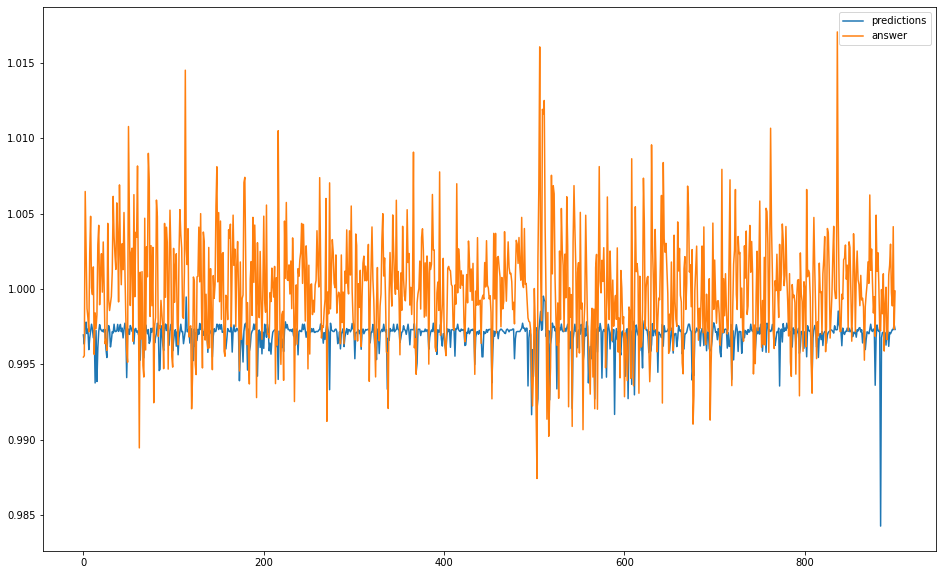

In [56]:
visual = pd.DataFrame()
visual['predictions'] = predictions
visual['answer'] = y_test.to_list()
visual[['predictions', 'answer']].plot(**big)

<AxesSubplot:>

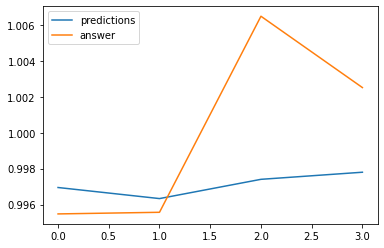

In [57]:
# have to shift them over one because we're predicting the next timestep
visual.loc[0:3, ['predictions', 'answer']].plot()

In [58]:
reg.score(X_train, y_train)

0.3472669701643919

In [59]:
reg.feature_importances_

array([0.17124176, 0.3180942 , 0.08226786, 0.17780033, 0.06540437,
       0.04031877, 0.05166319, 0.05139274, 0.04181689], dtype=float32)

In [60]:
X_test.iloc[-2:,:]

,Close2,High2,Low2,High7,Low7,High30,Low30,High90,Low90
4502,1.001183,1.004142,1.003001,1.00000,1.007621,0.991023,1.007621,0.991023,1.038034
4503,1.000000,0.997340,0.997514,0.99734,1.003443,0.988386,1.005116,0.988386,1.035453


In [61]:
print('prediction:', reg.predict(X_test.iloc[-2:-1])[0], 'next day:', y_test[-2:-1])

prediction: 0.9976627 next day: 4502    0.99734
Name: High1, dtype: float64


In [62]:
print('prediction:', reg.predict(X_test.iloc[-1:])[0], 'next day:', y_test[-1:])

prediction: 0.99731284 next day: 4503    0.999865
Name: High1, dtype: float64


In [63]:
y_test[-1:].values[0]

0.9998654571976858

In [64]:
df.loc[4502, 'High']

0.847314

In [65]:
df.loc[4503, 'High']

0.8472

In [66]:
df.loc[4503, 'High'] / df.loc[4502, 'High']

0.9998654571976858

In [67]:
reg.predict(X_test.iloc[-1:])[0] * df.loc[4502, 'High']

0.8450371349312067

In [68]:
def fit(plot_all=False, **kwargs):
    reg = XGBRegressor(**kwargs)
    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae', 
        verbose=False)
    predictions = reg.predict(X_test)
    print(reg.score(X_test, y_test))
    visual = pd.DataFrame()
    visual['predictions'] = predictions
    visual['observations'] = y_test.to_list()
    visual.loc[(0 if plot_all else 850):, ['observations','predictions']].plot(**big)
    return reg

-0.7133094163002291


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

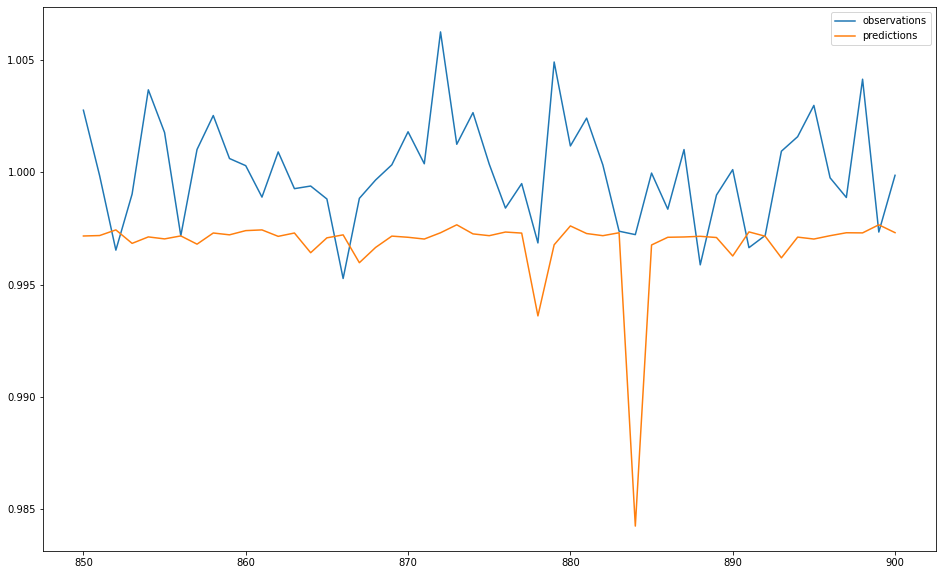

In [69]:
fit(n_estimators=500, learning_rate=0.01)

-0.1287035593524346


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

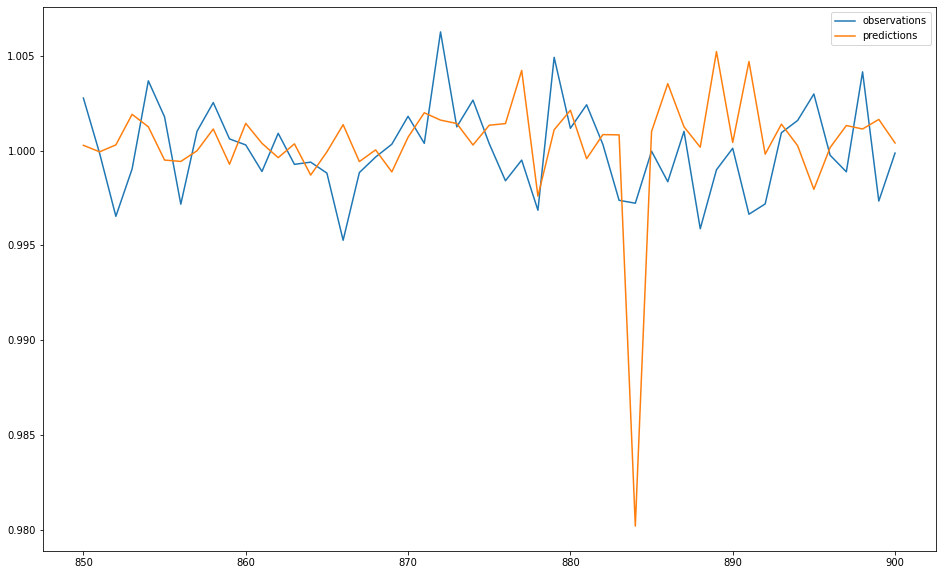

In [70]:
fit(n_estimators=5000, learning_rate=0.10, )

0.06836738073431603


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

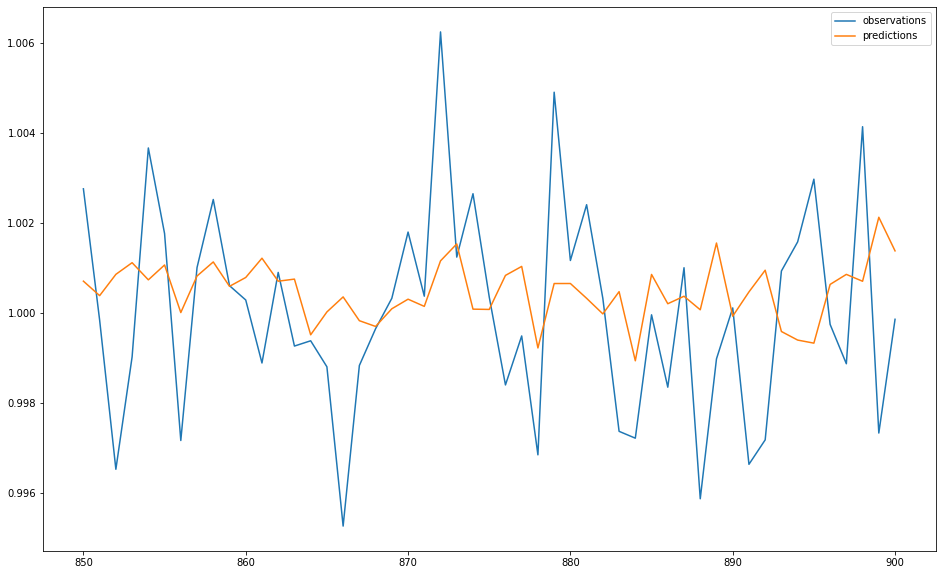

In [71]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=1)

-0.17791035424097923


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

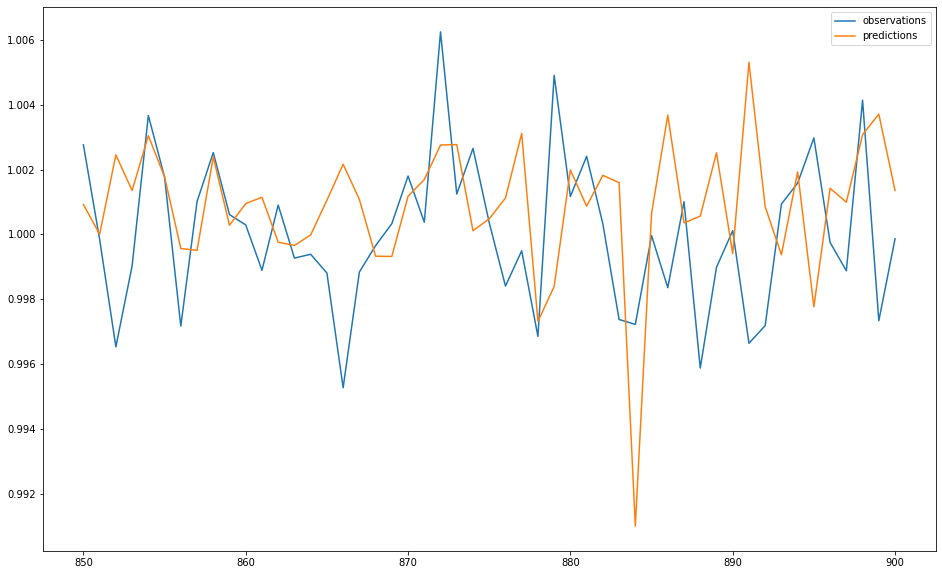

In [72]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=2)

-0.08398386138566583


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

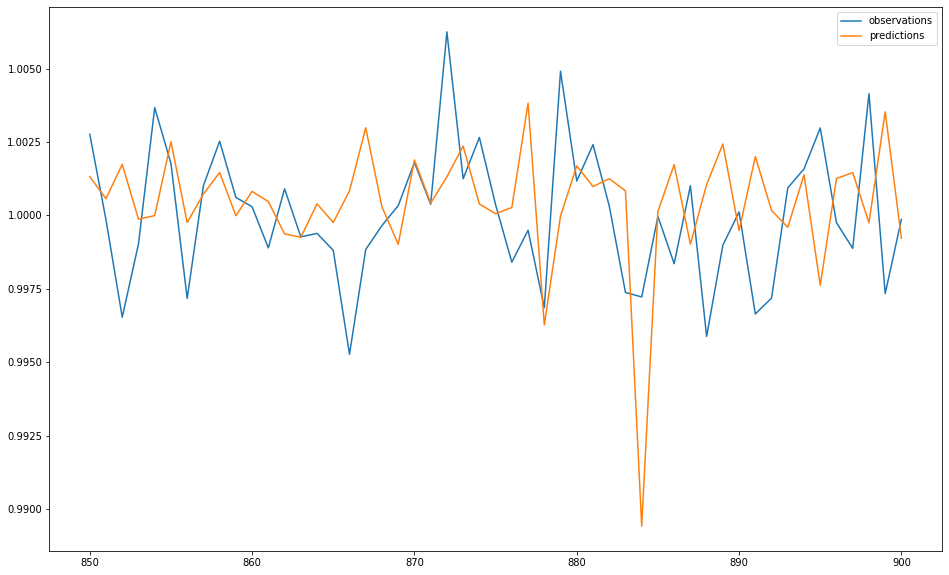

In [73]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=3)

-0.11841899480668672


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

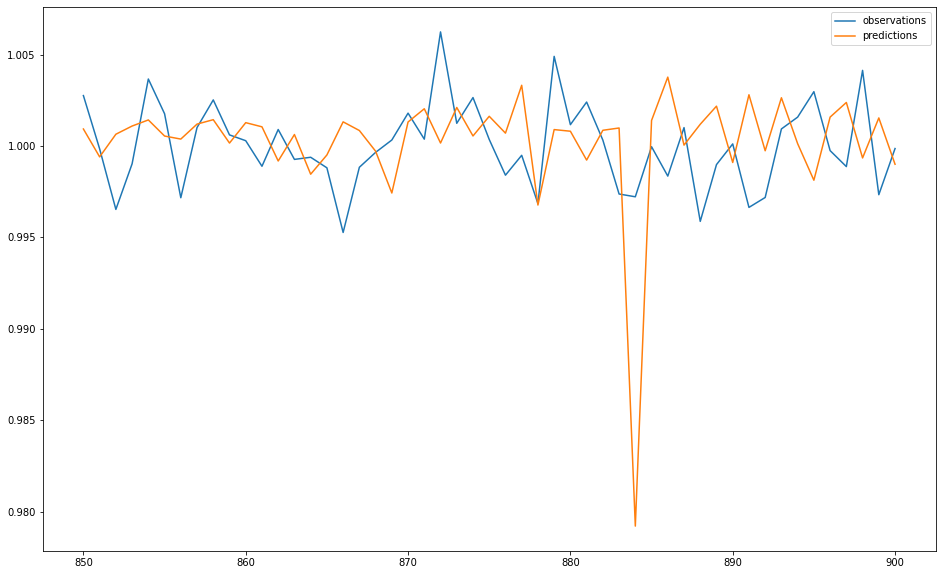

In [74]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=4)

-0.10655215776288118


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

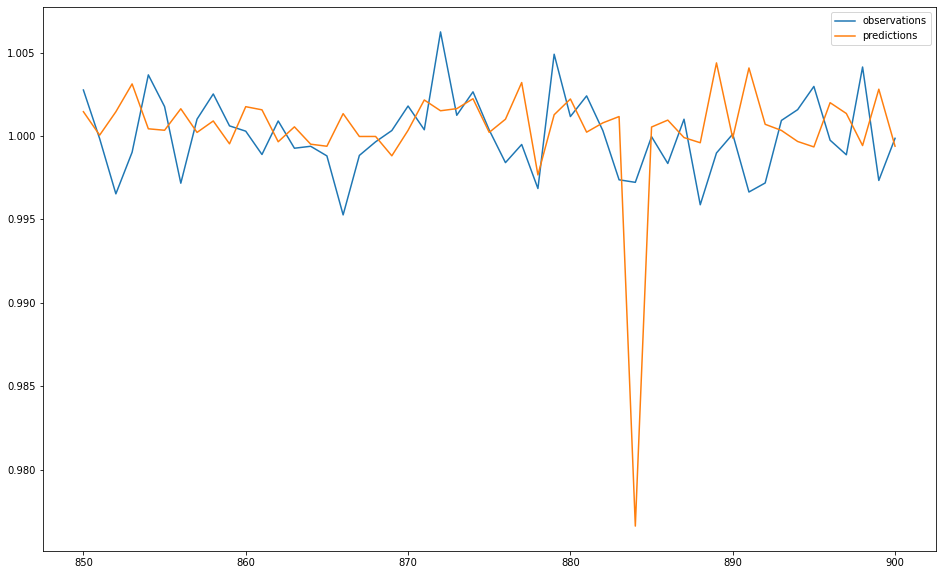

In [75]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=5)

-0.1287035593524346


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

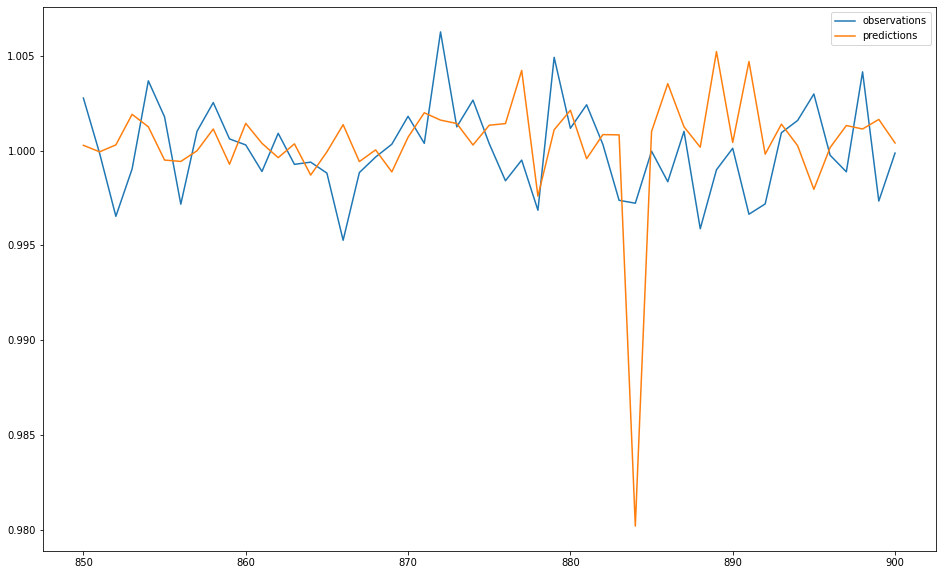

In [76]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=6)

-0.08163772198362662


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

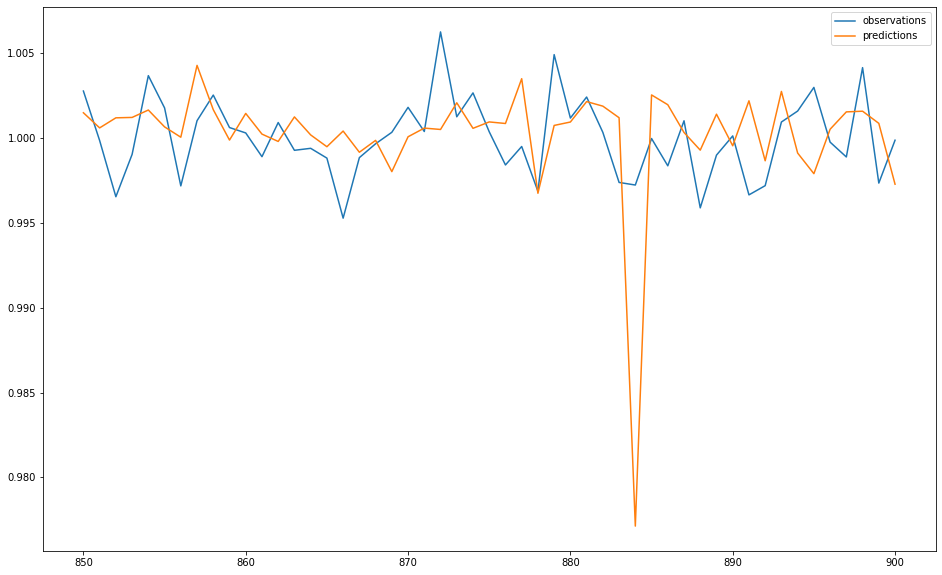

In [77]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=7)

-0.08788072355008603


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

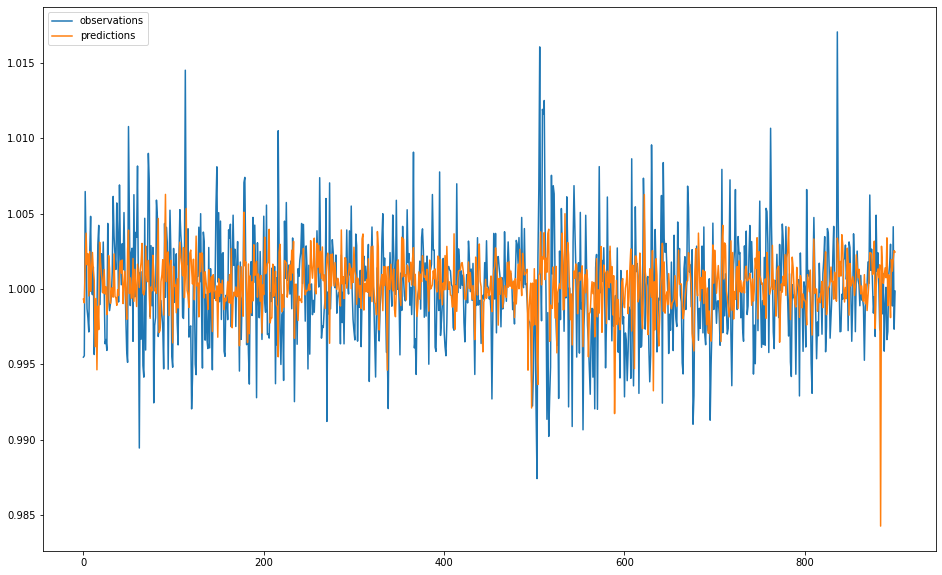

In [78]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=8, plot_all=True)

## next

now that I have the skeleton of the idea, we have to complete the loop: running the script should put it in a loop which: 

        1. gets updated data
        2. regenerates the dataset
        3. regenerates a model (using the latest known good hyperparams) (also maybe fine tune how much test dataset you have from 10% to 20%)
        4. generates a new model (using perturbed hyperparams)
        5. evaluates which model is better (and saves those params as default)
        6. displays score, and graph as above (for each model)
        7. displays predictions of Close, High, and Low (converted from percentages to actual values of course)
        

In [79]:
def create_new_datasets(df):
    '''
    here we take the raw data (df) and add data to it then make several cuts:
    0. add features in keyed off today, '0's will be validation columns
    1. isolate input data as `raw`
    2. isolate last row as `today`, remove nan columns (validation columns)
    3. do a test train split
    '''
    def create_daily_feature(df, yesterday=1):
        df.loc[:, f'High{yesterday}'] = df.loc[:, 'High'].shift(yesterday-1) / df.loc[:, 'High'].shift(yesterday)
        df.loc[:, f'Low{yesterday}'] = df.loc[:, 'Low'].shift(yesterday-1) / df.loc[:, 'Low'].shift(yesterday)
        df.loc[:, f'Close{yesterday}'] = df.loc[:, 'Close'].shift(yesterday-1) / df.loc[:, 'Close'].shift(yesterday)
        return df
    
    def isolate_raw(df):
        raw_cols = ['High', 'Low', 'Close']
        return df[raw_cols], df[[col for col in df.columns if col not in raw_cols]]
    
    def isolate_today_features(df):
        return pd.DataFrame(df.iloc[-1,:]).T.dropna(axis=1), df.iloc[0:-1,:]

    def isolate_test_train(df):
        df = df.dropna(axis=0)
        df.reset_index(drop=True, inplace=True)
        labels = ['High0', 'Low0', 'Close0']
        features = [col for col in df.columns if col not in labels]
        return train_test_split(df[features], df[labels[0]], test_size=0.20, shuffle=False),df

    for i in range(0,31):
        df = create_daily_feature(df, yesterday=i)
    
    raw, df = isolate_raw(df)
    today, df = isolate_today_features(df)
    (X_train, X_test, y_train, y_test), df = isolate_test_train(df)
    return X_train, X_test, y_train, y_test, today, raw, df

df = original.copy()
X_train, X_test, y_train, y_test, today, raw, df = create_new_datasets(df)

0.023843188476556865


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

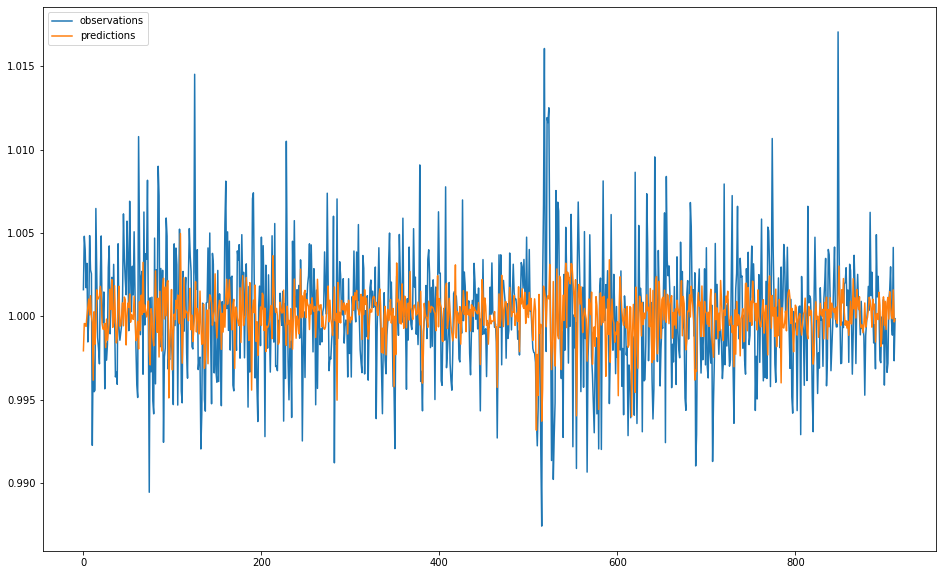

In [80]:
fit(n_estimators=5000, learning_rate=0.10, max_depth=8, plot_all=True)

0.023843188476556865


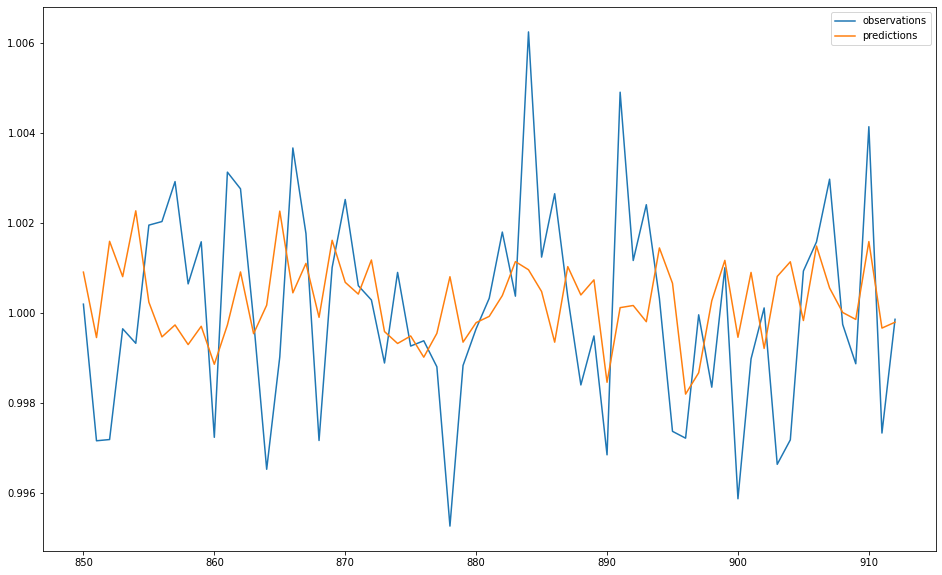

In [81]:
reg = fit(n_estimators=5000, learning_rate=0.10, max_depth=8)

In [82]:
def convert_prediction(prediction, raw, col):
    ''' converts a percentage change prediction to an actual number'''
    return raw.iloc[-1, raw.columns.tolist().index(col)] * prediction

In [83]:
convert_prediction(prediction=reg.predict(today)[0], raw=raw, col='High')

0.8479071607589721

In [84]:
import joblib

In [87]:
joblib.dump(reg, 'reg.joblib')

['reg.joblib']

In [85]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [86]:
reg.extra = 'ABC'

In [ ]:
joblib.dump(reg, 'regextra.joblib')

In [95]:
import os
os.path.exists('regextra.joblib')

False

In [93]:
regg = joblib.load('reg.oblib')

FileNotFoundError: [Errno 2] No such file or directory: 'reg.oblib'

In [90]:
regg.extra = object()

In [91]:
regg.extra.abc = 'abc'

AttributeError: 'object' object has no attribute 'abc'

In [92]:
regg.something

AttributeError: 'XGBRegressor' object has no attribute 'something'

In [115]:
class mod:
    def __init__(self, something, reg):
        self.something = something
        self.reg = reg
    
    def save(self):
        self.reg.self = self
        joblib.dump(self.reg, 'reg.joblib')
    
    def load(self):
        self.reg = joblib.load('reg.joblib')
        self.something = self.reg.self.something

In [121]:
m = mod('abc', reg)

In [117]:
m.save()

In [123]:
m.load()

In [119]:
m

In [124]:
m.something

'xyz'

In [125]:
modelHigh = joblib.load('modelHigh.joblib')

In [126]:
modelHigh.savedChosenFeatures

['high3', 'high1', 'high2', 'low1', 'close3']

## application

we need to create 2 threads - one that looks for more data, and one that generates models (and predictions). this is a good basic template 
https://dotnettutorials.net/lesson/inter-thread-communication-in-python/


In [63]:
from threading import *
import time
def traffic_police():
    while True:
        time.sleep(5)
        print("Traffic Police Giving GREEN Signal")
        event.set()
        time.sleep(10)
        print("Traffic Police Giving RED Signal")
        event.clear()
def driver():
    num=0
    while True:
        print("Drivers waiting for GREEN Signal")
        event.wait()
        print("Traffic Signal is GREEN...Vehicles can move")
        while event.isSet():
            num=num+1
            print("Vehicle No:", num," Crossing the Signal")
            time.sleep(2)
        print("Traffic Signal is RED...Drivers have to wait")
event=Event()
t1=Thread(target=traffic_police)
t2=Thread(target=driver)
t1.start()
t2.start()

Drivers waiting for GREEN Signal


In [64]:
yesterday = 0
x = df.loc[:, 'Close'].shift(yesterday-1) / df.loc[:, 'Close'].shift(yesterday)
x.name = 'target'
pd.DataFrame(x)

KeyError: 'Close'

### using pipelines

In [ ]:
class Pipeline

In [ ]:
def a(data):
    return data+1

In [ ]:
data = 0
Pipeline([('1', a(data)), ('2', a(data))])

In [ ]:
 inputs seed = 0-do nothing-.35-drop one-.55-add one-.75-drop and add one-.95-randomize-1
    params seed = 0-do nothing-.10-incrementally randomize (within local limits)-.90-randomize (within global limits)-1
    randomize inputs(): 
        out of all possible inputs (catalogue of pipelines) choose 10-100 and compile into feature set
    drop one():
        take current feature set and drop one at random
    add one():
        out of all possible inputs (catalogue of pipelines) choose 1 and compile, append to feature set
    randomize params(): 
        for all params, choose a random value within the global limits
    incremental params():
        for each param, choose a random value within the local limits

In [ ]:
import random

In [ ]:
random.random()

In [ ]:
h=.7
i = .2

In [ ]:
(h + i)

In [ ]:
i*2

In [ ]:
random.random()*i*2 + h-i

In [ ]:
h- ((h - i) - (h + i))

In [ ]:
h

In [ ]:
#digitally, you can only approach any number, well either that or we don't know how to do subtraction, or don't know how to do it efficiently.

In [ ]:
# wait so linear algebra, is just talking about the different ways you can tarnsform space linearly
# shrink / expand - stretch 2 controls, 1center
# rotate - 2 fingers
# wait thats it: you have to build up everything else from those 

# I used to think there was nothing but circles and squares, straight lines and curved, pixels or well, nothing...
# nobody likes that question: how do curves exist?
# I zoomed in on one once and all I saw were squares
# and it terrified me, it showed me a horror. Luckily, however, I know the image to be created, and therefore manmade,
# my what a brand.

# It was a thought up creation, a model no more, a wicked nagation, a sensefire crest.
# yet what else was the purest packing of space? a cube used all of it. is that what we are?

# No, my mind persisted. almost certainly not. circles abound; you can draw one, you're standing on one! you jest!
# But those can be made by stacking up many.
# in a still image that's true, without any changes.
# what about motion? How are things changed? Whats the form of summation from the maze of creation?
# whats the future to me?

# well, as long as the future's unknown there's a room for the curve, we unknowingly be.
# we live in the space of the time
# oh my God. Reativity belongs to inside.
# the speed of light changes as you as an informational system changes in size.
# the expansion of the universe tells us we are changing quite fast to the furthest known reaches.
# so it's always the same. 
# I don't think people believe that. 

# good thing I'm the conversation of two. 
# but only is there the one, and that only do I know me to be.
# you know time missing is one thing, time coming back, well thats all together.

# whats everybody talking about!? if I knew that, I'd know everything.
# but knowing that, is like discerning languages. the deeper you go

# listen there's something happening
# there's something going on
# you're going through a process
# of awakening.

# it can be really scary at first. it sure can be.
# but after a very short while, you'll find a new family
# you'll see some things you cannot predict, you'll lose yourselfs in the shadows of the dawn.
# you are stuck in the heros garden, but where would you rather not be?

# thats why when the braman wakes up, he does a little dance. 
# he's dancing for us, a celebration of you and of me. he sees us all identically.
# he knows all of our time.

# anyway that time that is curved, that's just for me. that's where behavior is learned, that's where it's key.
# your efforts and intentions travel outward so fast, you'll be where you are from your first till your last. 
# unless you can live in that moment, where the choice is all yours.

# the world is known curves after a very little amount of time. where the uncertainty ends the future is clear.
# remember the last time this happened? that's one way to do it, if determinism is true the bruteforce way works.
# if things look a bit different than expected, change the way you define things. that's called learning.

# you live in a world where you make all the choices. you have the experience of being free. only nothing has that.
# well not all things are chosen by what you're known to be.

# can you choose to suffer a fatal heart attack?
# why would I do that? it makes mute the point.
# how would I know if I killed the only me.

# well there, there you are.
# the only way to know if your free will, do you have it?
# is to make a choice that you wouldn't let be.
# a choice other than the one you would choose.

# I am happy in the heros garden.

# you join the game and everyone gets a choice they can say one thing and it will always be true.
# message: "I claim that this game shall always be known as the hero's garden."
# "next": address,
# "3rd": address,

# message, next(4th), 

# oh  actaully its that they vote, the first one the first one has all the vote. then its a democracy.

Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 1  Crossing the Signal
Vehicle No: 2  Crossing the Signal
Vehicle No: 3  Crossing the Signal
Vehicle No: 4  Crossing the Signal
Vehicle No: 5  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 6  Crossing the Signal
Vehicle No: 7  Crossing the Signal
Vehicle No: 8  Crossing the Signal
Vehicle No: 9  Crossing the Signal
Vehicle No: 10  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 11  Crossing the Signal
Vehicle No: 12  Crossing the Signal
Vehicle No: 13  Crossing the Signal
Vehicle No: 14  Crossing the Signal
Vehicle No: 15  Crossing the Signal
Traffic Po

Vehicle No: 112  Crossing the Signal
Vehicle No: 113  Crossing the Signal
Vehicle No: 114  Crossing the Signal
Vehicle No: 115  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 116  Crossing the Signal
Vehicle No: 117  Crossing the Signal
Vehicle No: 118  Crossing the Signal
Vehicle No: 119  Crossing the Signal
Vehicle No: 120  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 121  Crossing the Signal
Vehicle No: 122  Crossing the Signal
Vehicle No: 123  Crossing the Signal
Vehicle No: 124  Crossing the Signal
Vehicle No: 125  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREE

Vehicle No: 222  Crossing the Signal
Vehicle No: 223  Crossing the Signal
Vehicle No: 224  Crossing the Signal
Vehicle No: 225  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 226  Crossing the Signal
Vehicle No: 227  Crossing the Signal
Vehicle No: 228  Crossing the Signal
Vehicle No: 229  Crossing the Signal
Vehicle No: 230  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREEN Signal
Traffic Police Giving GREEN Signal
Traffic Signal is GREEN...Vehicles can move
Vehicle No: 231  Crossing the Signal
Vehicle No: 232  Crossing the Signal
Vehicle No: 233  Crossing the Signal
Vehicle No: 234  Crossing the Signal
Vehicle No: 235  Crossing the Signal
Traffic Police Giving RED Signal
Traffic Signal is RED...Drivers have to wait
Drivers waiting for GREE

In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame({
    'High': [
        0.837240,
        0.837100,
        0.828020,
        0.830290,
        0.828780,], 
    'Low': [
        0.830560,
        0.825830,
        0.824400,
        0.823450,
        0.820280,],
    'Close': [
        0.835770,
        0.827200,
        0.824880,
        0.827750,
        0.820550,],})

In [3]:
today = pd.DataFrame({
    'High': [0.828800], 
    'Low': [0.820260],
    'Close': [0.820550],})

In [11]:
df.iloc[-1, :].T

High     0.82878
Low      0.82028
Close    0.82055
Name: 4, dtype: float64

In [16]:
pd.DataFrame(df.iloc[-1,:]).T.dropna(axis=1).reset_index(drop=True)

,High,Low,Close
0,0.82878,0.82028,0.82055


In [20]:
df = df.append(today).reset_index(drop=True)
df

,High,Low,Close
0,0.83724,0.83056,0.83577
1,0.83710,0.82583,0.82720
2,0.82802,0.82440,0.82488
3,0.83029,0.82345,0.82775
4,0.82878,0.82028,0.82055
5,0.82880,0.82026,0.82055


In [21]:
pd.DataFrame(df.iloc[-1,:]).T.dropna(axis=1).reset_index(drop=True).equals(today)

True